# Ensemble methods: Technical preamble

## Interactivity

Please, run the next cell and **refresh the page with the notebook** in your browser.

This enables interactive features.

In [1]:
# !pip install ipywidgets
# !conda install -c conda-forge ipywidgets
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Enable interactivity

In [2]:
from ipywidgets import widgets

Interactive sliders

In [3]:
def int_slider(value, min, max, step):
    return widgets.IntSlider(
        value=value, min=min, max=max, step=step, 
        continuous_update=False, layout=widgets.Layout(min_width='500px', display='flex'))

def float_slider(value, min, max, step):
    return widgets.FloatSlider(
        value=value, min=min, max=max, step=step,
        continuous_update=False, layout=widgets.Layout(min_width='500px', display='flex'))

## Imports and declarations

In [4]:
import numpy  as np

%matplotlib inline
import matplotlib.pyplot as plt

Scikit learn service imports

In [5]:
from sklearn import datasets
from sklearn.metrics import auc, roc_curve

from sklearn.model_selection import train_test_split
    
from sklearn.utils import check_random_state

Handy plotting functions

In [6]:
def draw_contour(axis, X, Y, Z, num=11):
    l, u = Z.min(), Z.max()
    if u <= l:
        u, l = l + 0.01, u - 0.01
    axis.contourf(X, Y, Z.reshape(X.shape), cmap=plt.cm.Purples,
                  levels=np.linspace(l, u, num=num), zorder=-99)
    axis.contour(X, Y, Z.reshape(X.shape), linewidths=4,
                 colors="orange", levels=[(l + u) * 0.5,], zorder=-95)
    return axis
    
def draw_two_class_sample(axis, X, y, cmap=plt.cm.bone, pred=None, **kwargs):
    errors = y != (y if pred is None else pred)
    for i, (cls_, col_) in enumerate(zip(np.unique(y), cmap([0.0, 1.0]))):
        mask = y==cls_
        XX, is_error = X[mask, ...], errors[mask]
        axis.scatter(XX[:, 0], XX[:, 1], marker="v^"[i], c=col_, **kwargs)
        axis.scatter(XX[is_error, 0], XX[is_error, 1],
                     marker="v^"[i], c="red", zorder=+99)

    return axis

Service functions for plotting

In [7]:
def plot_one_axis(axis, estimator, fmt="%(name)s AUC:%(auc)0.2f", test_errors=True):
    draw_contour(axis, *mesh_, Z=estimator.predict_proba(mesh)[:, 1])
    draw_two_class_sample(axis, X_train, y_train, s=5,
                          alpha=0.75, label="train", zorder=-50)

    if test_errors:
        y_pred = estimator.predict(X_test)
        draw_two_class_sample(axis, X_test, y_test, pred=y_pred,
                              alpha=0.95, label="test")
    else:
        y_pred = estimator.predict(X_train)
        draw_two_class_sample(axis, X_train, y_train, pred=y_pred,
                              alpha=0.95)

    y_pred = estimator.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    axis.set_title(fmt%dict(name=estimator.__class__.__name__,
                            auc=auc(fpr, tpr),
                            **estimator.__dict__))
    
    axis.set_xlabel("$x_1$")
    axis.set_ylabel("$x_2$")

    legend = axis.legend(shadow=True, ncol=2,
                         fontsize="small", loc="upper right")
    legend.get_frame().set_facecolor("thistle")

    return axis

def plot_ensemble_one_axis(axis, ensemble, fmt="%(name)s AUC:%(auc)0.2f"):
    for est_ in ensemble.estimators_:
        y_pred_ = est_.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_)
        axis.plot(fpr, tpr, color="red", alpha=0.25)

    y_pred_ = ensemble.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_)
    axis.plot(fpr, tpr, color="black",
              label=(fmt%dict(name=ensemble.__class__.__name__,
                              auc=auc(fpr, tpr),
                              **ensemble.__dict__)))

    axis.legend(fontsize="xx-large", loc="lower right")
    axis.set_xlim(-0.01, 1.01)
    axis.set_ylim(-0.01, 1.01)
    axis.set_xlabel("FPR")
    axis.set_ylabel("TPR")

    return axis

def plot_pair_figure(left, right, fmt="%(name)s AUC:%(auc)0.2f"):
    fig = plt.figure(figsize=(16, 7.5))

    plot_one_axis(fig.add_subplot(121), left, fmt)
    plot_one_axis(fig.add_subplot(122), right, fmt)
    return fig

def plot_one_figure(estimator, fmt="%(name)s AUC:%(auc)0.2f"):
    fig = plt.figure(figsize=(12, 8))
    plot_one_axis(fig.add_subplot(111), estimator, fmt)
    return fig

<br/>
<br/>
<hr/>
<br/>
<br/>

# Ensemble methods: Practical session

## Classification

Estimators

In [8]:
from xgboost import XGBClassifier

from sklearn.ensemble import BaggingClassifier, \
                             RandomForestClassifier, \
                             AdaBoostClassifier, \
                             GradientBoostingClassifier
            
from sklearn.tree import DecisionTreeClassifier

Toy data generator for two-class classification

In [9]:
def make_classification(n_samples, random_state=None):
    return datasets.make_classification(
        n_samples, n_features=2, n_classes=2, n_clusters_per_class=1,
        n_redundant=0, n_informative=2, random_state=random_state)
    return datasets.make_moons(
        n_samples=n_samples, noise=0.20,
        random_state=random_state)

Generate some synthetic data

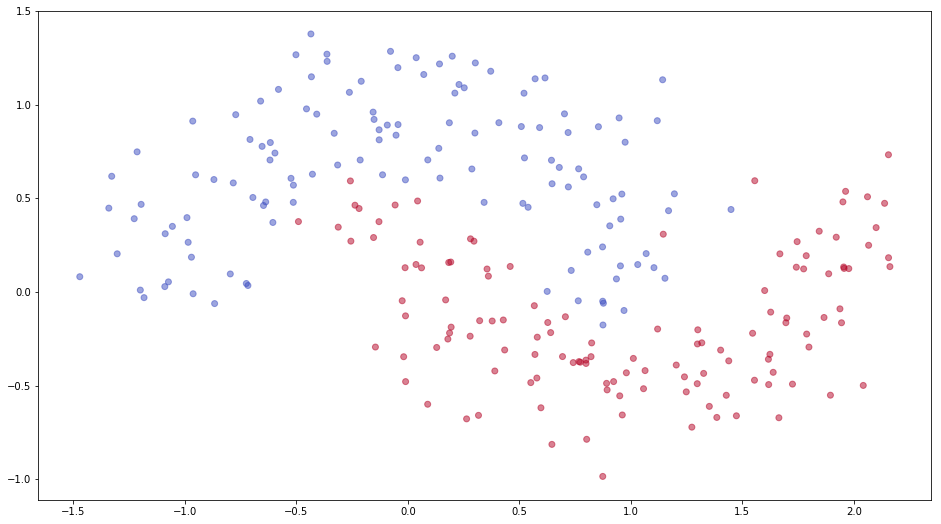

In [10]:
X, y = datasets.make_moons(n_samples=251, noise=0.20,
                           random_state=0x0DEAD0F8)
# X, y = datasets.make_classification(
#     n_samples=n_samples,n_features=2, n_classes=2, n_clusters_per_class=1,
#         n_redundant=0, n_informative=2, random_state=random_state)

ax = plt.figure(figsize=(16, 9)).add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha=0.5);

Prepare a 2d mesh for contour plotting

In [11]:
mesh_ = np.meshgrid(*[np.linspace(l, h, num=51)
                      for l, h in zip(X.min(axis=0)*1.15,
                                      X.max(axis=0)*1.15)])

mesh = np.stack([crd_.ravel()
                 for crd_ in mesh_], axis=1)

Train/test split

In [12]:
split_ = train_test_split(X, y, test_size=0.5,
                          random_state=0x0EE1F00D)

X_train, X_test, y_train, y_test = split_

### Bagging

Key hyperparameters:
* base estimator calss $\hat{f}$ (`base_estimator`)
* size of the ensemble $T$ (``n_estimators``)
* bootstrap sample size ratio $\frac{n}{m}$ (``max_samples``)

In [13]:
def BaggingClassifier_plot(max_depth=3, n_estimators=10, max_samples=1.0):
    estimator = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=0x10AFF00D)
    
    estimator.fit(X_train, y_train)

    fig = plt.figure(figsize=(16, 7.5))
    plot_one_axis(fig.add_subplot(121), estimator,
                  fmt="""%%(name)s (%s, %%(n_estimators)d,"""\
                      """%%(max_samples)0.2f) AUC:%%(auc)0.2f"""%(
                          "$\\infty$" if max_depth is None else max_depth,))
    plot_ensemble_one_axis(fig.add_subplot(122), estimator)
    plt.show()

Let's see how they affect the ensemble

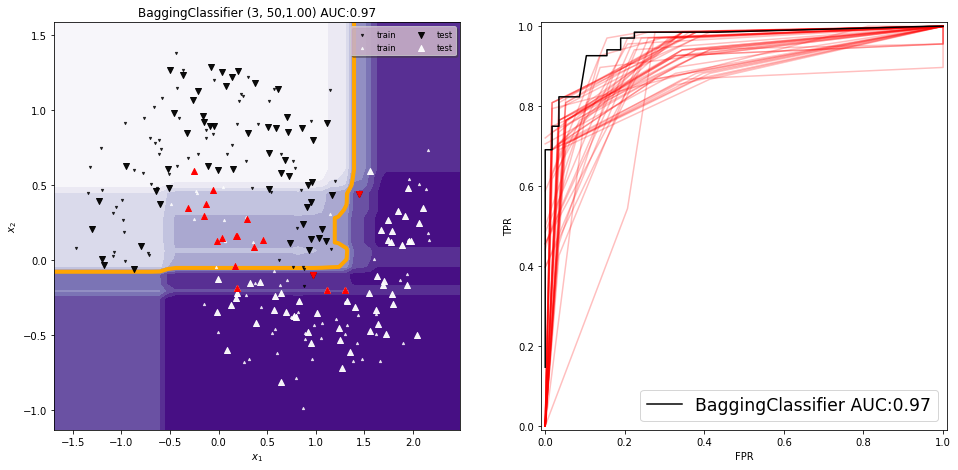

In [14]:
widgets.interact(BaggingClassifier_plot,
                 n_estimators=int_slider(50, 1, 250, 10),
                 max_samples=float_slider(1.0, 0.05, 1.0, 0.05),
                 max_depth={"1": 1, "2": 2, "3": 3, "5": 5, "∞": None});

Let's have a side-by-side comparison of two ensembles

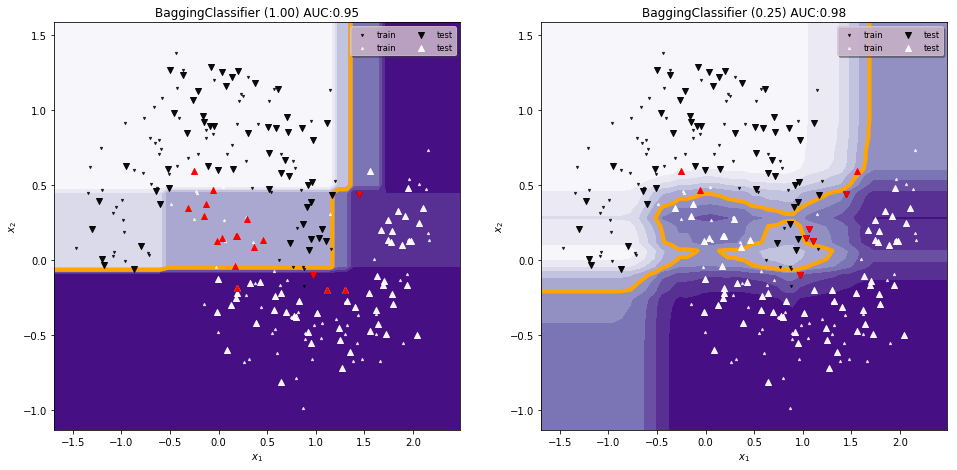

In [15]:
left = BaggingClassifier(DecisionTreeClassifier(max_depth=3),
                         n_estimators=3,
                         max_samples=1.0,
                         random_state=0x10AFF00D)

right = BaggingClassifier(DecisionTreeClassifier(max_depth=None),
                          n_estimators=333,
                          max_samples=0.25,
                          random_state=0x10AFF00D)

plot_pair_figure(left.fit(X_train, y_train), right.fit(X_train, y_train),
                 fmt="%(name)s (%(max_samples)0.2f) AUC:%(auc)0.2f");

### AdaBoost

Key hyperparamters:
* base estimator calss $\hat{f}$ (`base_estimator`)
* size of the ensemble $T$ (``n_estimators``)

In [16]:
def AdaBoostClassifier_plot(max_depth=1, n_estimators=10):
    estimator = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        random_state=0x10AFF00D)

    estimator.fit(X_train, y_train)

    fig = plt.figure(figsize=(16, 7.5))
    plot_one_axis(fig.add_subplot(121), estimator,
                  fmt="""%%(name)s (%s, %%(n_estimators)d) AUC:%%(auc)0.2f"""%(
                      "$\\infty$" if max_depth is None else max_depth,))
    plot_ensemble_one_axis(fig.add_subplot(122), estimator)
    plt.show()

Let's see how they affect the ensemble

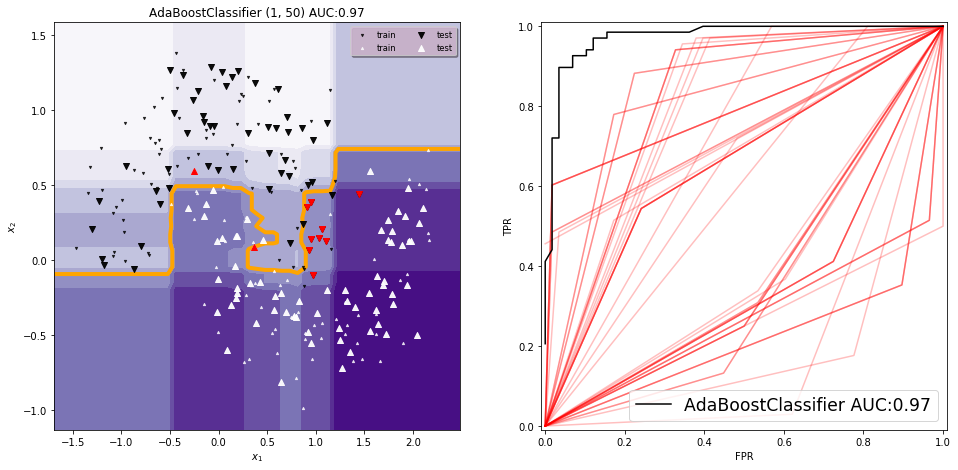

In [17]:
widgets.interact(AdaBoostClassifier_plot,
                 n_estimators=int_slider(50, 1, 150, 10),
                 max_depth=int_slider(1, 1, 20, 1));

Now a side-to-side comparison

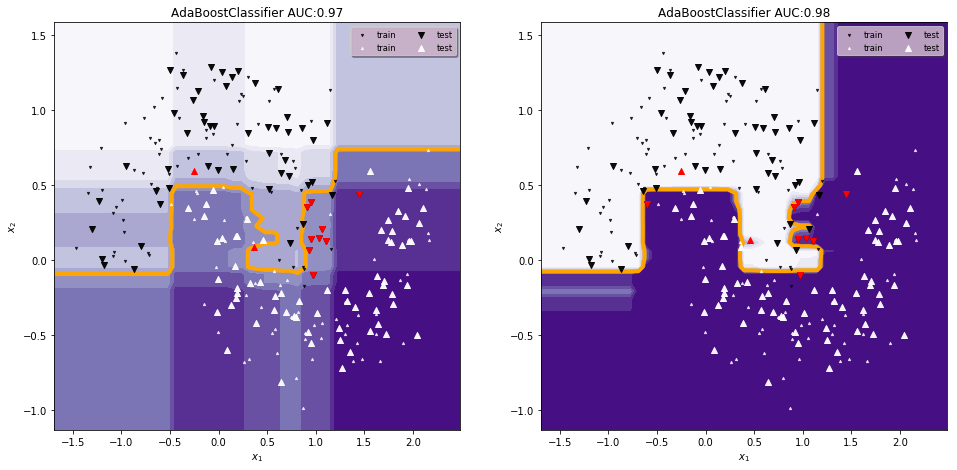

In [18]:
left = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=0x10AFF00D)

right = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    random_state=0x10AFF00D)

plot_pair_figure(left.fit(X_train, y_train), right.fit(X_train, y_train));

### XGBoost

Key hyperparameters:
* size of the ensemble `n_estimators`
* bootstrap sample size ratio (``subsample``)
* limit on tree depth (``max_depth``)
* $l_1$ penalty (``reg_alpha``)
* $l_2$ penalty (``reg_lambda``)
* tree-depth cost for pruning (``gamma``)
<!-- * fraction of projections for the whole tree (``colsample_bytree``) -->
<!-- * random projection at each split (``colsample_bylevel``) -->

In [19]:
def XGBClassifier_plot(max_depth=3, n_estimators=10,
                       subsample=1.0):
    estimator = XGBClassifier(
        max_depth=max_depth,          # Depth of each regression tree
        n_estimators=n_estimators,    # Size of the ensemble
        subsample=subsample,          # bootstrap share

        reg_alpha=0.0,                # L_1 leaf weight penalty
        reg_lambda=1.0,               # L_2 leaf weight penalty
        gamma=0.0,                    # cost of each new leaf
        learning_rate=0.1,

        objective='binary:logistic',
        seed=0x10AFF00D,
        nthread=2)
    
    plot_one_figure(estimator.fit(X_train, y_train),
                    fmt="""%(name)s (%(n_estimators)d, %(max_depth)d, """ \
                        """%(subsample)0.2f) AUC:%(auc)0.2f""")
    plt.show()

Let's see how XGBoost classifier depends on the ensemble hyperparamters

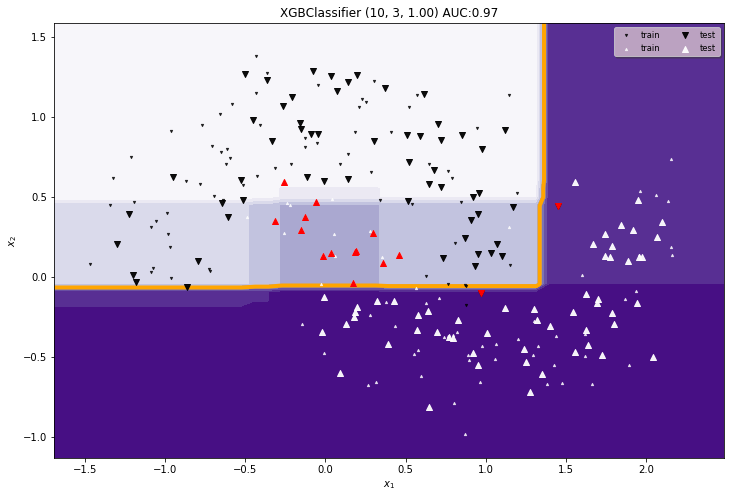

In [20]:
widgets.interact(XGBClassifier_plot,
                 n_estimators=int_slider(10, 1, 1000, 10),
                 max_depth=int_slider(3, 1, 20, 1),
                 subsample=float_slider(1.0, 0.05, 1.0, 0.05));

Side-by-side comparison

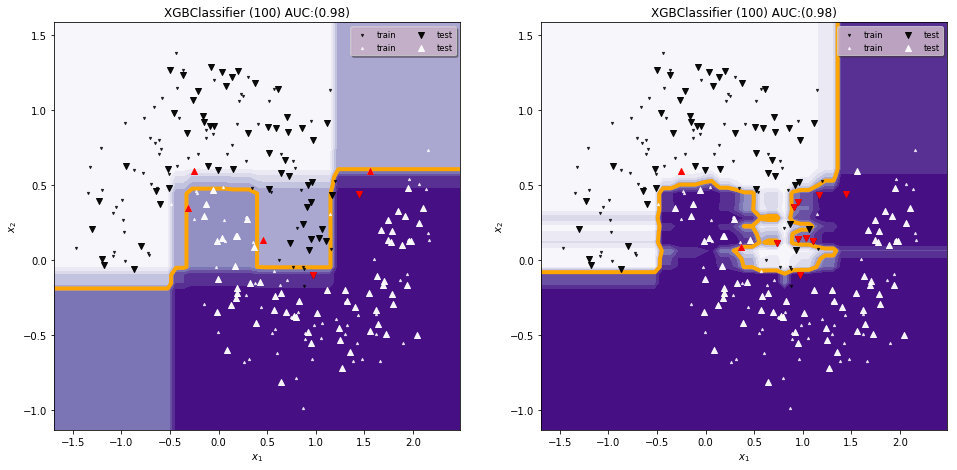

In [21]:
left = XGBClassifier(
    n_estimators=100,
    subsample=1.0,
    max_depth=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    learning_rate=0.1,
    seed=0x10AFF00D, nthread=8)

right = XGBClassifier(
    n_estimators=100,
    subsample=1.0,
    max_depth=3,
    reg_alpha=0.0,
    reg_lambda=1.0,
    learning_rate=1.0,
    seed=0x10AFF00D, nthread=8)

plot_pair_figure(left.fit(X_train, y_train), right.fit(X_train, y_train),
                 fmt="%(name)s (%(n_estimators)d) AUC:(%(auc)0.2f)");